#  Actividad 2 07MBID Machine Learning

**Nombre: Luis Millán Monte**

La actividad 2 consiste en la creación de un modelo que prediga el número de casos de Dengue en dos ciudades. Se trata de una competición de DrivenData. Mas información en [enlace](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)


# Resumen

En este cuaderno he realizado las siguientes tareas para la generación del modelo de predicción de casos de Dengue:
- Preprocesamiento: primero se desecharon las variables que no aportaban información y se interpolaron los missing values. También se dividió el dataset en dos para generar un modelo para cada ciudad. Se obtuvieron los promedios de las variables repetidas y se añadieron datos desplazados para que se tenga la información de las 2 últimas semanas cuando se vaya a predecir un número de casos.
- Selección de variables: para seleccionar las variables más relevantes, opté por ordenarlas según su valor de correlación frente a la variable objetivo, los casos de dengue, y seleccioné las 6 más correladas para cada modelo. Se eliminaron los outliers detectados y se normalizaron los datos
- Elección del modelo: Tras realizar varias pruebas con distintos modelos: regresión linal, knn, randomforest, autoregresivos (series temporales), el que mejor resultado dió fue el randomforest
- Optimización de hiperparámetros: Los hiperparámetros de cada modelo se optimizarón siguiendo una búsqueda aleatorio sobre una serie de parámetros.
- Entrenamiento de los 2 modelos con los mejores hiperparámetros seleccionados
- Predicción de los casos en el dataset de test
- Resultado obtenido en DrivenData: **MAE = 24,43**

# Carga de librerías

Antes de empezar cualquier análisis hay que asegurar que las librerías básicas y de uso general (numpy, pandas, etc.) están correctamente importadas. 

In [1]:
# carga de datos
import pandas as pd
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import io
import seaborn as sns


# Carga de Datos

En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

In [2]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

En primer lugar subimos los datos de entrenamiento sin campo objetivo (dengue_features_train)


In [3]:
train_feat = upload_files()
train_feat.tail()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,iq,2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [4]:
train_feat.shape

(1456, 24)

Posteriormente subimos los datos que únicamente nos proporcionan el número de casos de dengue para las semanas de entrenamiento (dengue_labels_train)

In [5]:
train_labels = upload_files()
train_labels.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Mezclamos los dos conjuntos de datos para tenerlos en un único dataframe

In [6]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [7]:
train.shape

(1456, 25)

Finalmente subimos los datos para generar la evaluación final (dengue_features_test)

In [8]:
test = upload_files()
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [9]:
test.shape

(416, 24)

# Preproceso

Una vez cargados todos los datos en dataframes, hay que preprocesarlos para generar los inputs de los modelos. Como estamos trabajando con las caracterísiticas del modelo, hay que hacer las mismas transformaciones en los datos de entrenamiento y en los de test, para que luego se puedan utilizar correctamente para predecir los casos de dengue en el dataset de test.
Lo primero que hacemos es eliminar 2 variables de tiempo que no nos van a aportar información al modelo ya que los casos no dependen del día que comienza la semana. Como tampoco hay una tendencia a lo largo de los años y además los datos de test son de años distintos a los de entrenamiento, esta variable también se elimina.
Se deja sin embargo el mes del año, ya que puede aportar información relevante si el número de casos tiene una componente estacional

In [10]:
train.drop(["week_start_date", "year"], axis = 1, inplace = True)
test.drop(["week_start_date", "year"], axis = 1, inplace = True)
train.head()

,city,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Posteriormente, se tratan los valores perdidos para evitar que den problemas a los modelos. Como los datos son semanales y consecutivos, se decide interpolar los missing values, ya que es de esperar que las variables meteorológicas de una semana se parezcan a los de la semana anterior y posterior 

In [11]:
pd.isnull(train).sum()

city                                       0
weekofyear                                 0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
total_case

In [12]:
train.interpolate(inplace=True)
pd.isnull(train).any()

city                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_preci

Y aplicamos lo mismo para el test

In [13]:
test.interpolate(inplace=True)
pd.isnull(test).any()

city                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_preci

### Selección de variables
A continuación, se obtiene las estadísticas más relevantes de las variables para ver que forma tienen

In [14]:
train.describe()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,26.503434,0.131490,0.127823,0.203130,0.201963,45.702091,298.697750,299.221723,295.244555,303.420158,...,82.173009,45.702091,16.744659,4.900618,27.181438,8.095505,32.446497,22.098043,39.362294,24.675137
std,15.019437,0.137272,0.119478,0.073781,0.083491,43.651356,1.359878,1.260384,1.525955,3.233153,...,7.152190,43.651356,1.540958,3.542762,1.281116,2.127521,1.959090,1.570524,47.285701,43.596000
min,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,13.750000,0.037400,0.048092,0.154057,0.144455,9.785000,297.657857,298.257143,294.117857,301.000000,...,77.196429,9.785000,15.554643,2.328571,26.314286,6.528571,31.100000,21.100000,8.850000,5.000000
50%,26.500000,0.115550,0.115926,0.195664,0.190121,38.320000,298.640000,299.285714,295.638571,302.400000,...,80.287857,38.320000,17.084286,2.857143,27.400000,7.350000,32.800000,22.200000,24.050000,12.000000
75%,39.250000,0.231443,0.213429,0.247461,0.246579,70.227500,299.827500,300.207143,296.457857,305.500000,...,86.437500,70.227500,17.976071,7.632143,28.130804,9.603571,33.900000,23.300000,53.900000,28.000000
max,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,...,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000


En el dataset aparecen varias variables repetidas, ya que provienen de bases de datos distintas: temperatura media, minima, máxima, precipitación total...
Para reducir la dimensionalidad y eliminar variables que indican lo mismo y por tanto muy correlacionadas entre si, se van a transformar columnas para quedarse solo con la media de las variables repetidas.
Como no todas las variables están en las mismas unidades, hay que convertirlas antes de hacer la  media. La temperatura está en Kelvin en las variables "reanalysis..." y en Celsius en las variables "station...". Para pasarla de Kelvin a Celsius hay que restarle 273.


In [15]:
# Temperatura media
train['temp_media'] = (train.reanalysis_air_temp_k - 273 + train.reanalysis_avg_temp_k - 273 + train.station_avg_temp_c)/3
test['temp_media'] = (test.reanalysis_air_temp_k - 273 + test.reanalysis_avg_temp_k - 273 + test.station_avg_temp_c)/3

# Precipitación total
train['prec_total'] = train[['precipitation_amt_mm','reanalysis_sat_precip_amt_mm', 'station_precip_mm']].mean(axis=1)
test['prec_total'] = test[['precipitation_amt_mm','reanalysis_sat_precip_amt_mm', 'station_precip_mm']].mean(axis=1)

# Temperatura máxima
train['temp_max'] = (train.station_max_temp_c + train.reanalysis_max_air_temp_k - 273)/2
test['temp_max'] = (test.station_max_temp_c + test.reanalysis_max_air_temp_k - 273)/2

# Temperatura mínima
train['temp_min'] = (train.station_min_temp_c + train.reanalysis_min_air_temp_k - 273)/2
test['temp_min'] = (test.station_min_temp_c + test.reanalysis_min_air_temp_k - 273)/2

# ndvi
train['ndvi_media'] = train[['ndvi_se','ndvi_sw', 'ndvi_ne', 'ndvi_nw']].mean(axis=1)
test['ndvi_media'] = test[['ndvi_se','ndvi_sw', 'ndvi_ne', 'ndvi_nw']].mean(axis=1)

train.drop(['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'station_avg_temp_c', 'precipitation_amt_mm','reanalysis_sat_precip_amt_mm', 
            'station_precip_mm', 'station_max_temp_c', 'reanalysis_max_air_temp_k', 'station_min_temp_c', 'reanalysis_min_air_temp_k', 
            'ndvi_se','ndvi_sw', 'ndvi_ne', 'ndvi_nw'], 
           axis = 1, inplace = True)
test.drop(['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'station_avg_temp_c', 'precipitation_amt_mm','reanalysis_sat_precip_amt_mm', 
            'station_precip_mm', 'station_max_temp_c', 'reanalysis_max_air_temp_k', 'station_min_temp_c', 'reanalysis_min_air_temp_k', 
            'ndvi_se','ndvi_sw', 'ndvi_ne', 'ndvi_nw'], 
           axis = 1, inplace = True)

Como tenemos 2 ciudades distintas, que pueden tener comportamientos diferentes, haremos un modelo para cada ciudad. Para ello dividimos el dataset en 2.

In [16]:
pd.options.mode.chained_assignment = None  # Para evitar que salga un warning que no afecta.

train_sj = train.loc[train.city == 'sj']
train_sj.drop('city', axis=1, inplace=True)
train_iq = train.loc[train.city == 'iq']
train_iq.drop('city', axis=1, inplace=True)
test_sj = test.loc[test.city == 'sj']
test_sj.drop('city', axis=1, inplace=True)
test_iq = test.loc[test.city == 'iq']
test_iq.drop('city', axis=1, inplace=True)
print("train_sj shape: ", train_sj.shape)
print("train_iq shape: ", train_iq.shape)
print("test_sj shape: ", test_sj.shape)
print("test_iq shape: ", test_iq.shape)

train_sj shape:  (936, 13)
train_iq shape:  (520, 13)
test_sj shape:  (260, 12)
test_iq shape:  (156, 12)


In [17]:
train_sj.head()

,weekofyear,reanalysis_dew_point_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_diur_temp_rng_c,total_cases,temp_media,prec_total,temp_max,temp_min,ndvi_media
0,18,292.414286,32.00,73.365714,14.012857,2.628571,6.900000,4,24.919524,13.613333,28.10,21.45,0.150606
1,19,293.951429,17.94,77.368571,15.372857,2.371429,6.371429,5,25.789524,18.080000,29.80,22.80,0.157479
2,20,295.434286,26.10,82.052857,16.848571,2.300000,6.485714,4,26.124762,36.826667,29.85,23.55,0.133315
3,21,295.310000,13.90,80.337143,16.672857,2.428571,6.771429,3,26.562381,11.573333,30.85,23.65,0.209286
4,22,295.821429,12.20,80.460000,17.210000,3.014286,9.371429,6,27.375238,6.946667,31.95,24.20,0.239235


Ponemos la columna 'total_cases', que es nuestra variable dependiente, al final del dataframe

In [18]:
cases_sj = train_sj.pop('total_cases')
train_sj.insert(len(train_sj.columns), 'total_cases', cases_sj)
cases_iq = train_iq.pop('total_cases')
train_iq.insert(len(train_iq.columns), 'total_cases', cases_iq)


Los casos de dengue es en realidad una serie temporal. Intente crear un modelo de serie temporal, pero aunque conseguía predecir muy bien los primeros valores, el modelo fallaba mucho al distanciarse en el tiempo. En este problema hay que predecir 416 valores en el futuro, que es mucho para una serie temporal. Sin embargo me di cuenta que tenía que tener en cuenta de alguna manera el tiempo, por lo que decidi añadir columnas con los datos desplazados, que muestren las variables meteorologicas de las 2 últimas semanas. Así se tiene en cuenta de alguna manera como fueron las 2 semanas anteriores y se puede predecir mejor. Para darle más peso a la última semana respecto a la anterior, decidi hacer una media ponderada, dando un 70% de peso a la última semana y un 30% a la anterior.

In [19]:
# Obtengo los nombres de las variables, excepto total_cases y weekofyear que no tienen sentido para esto
variables = train_sj.columns.drop(['total_cases','weekofyear'])

# Genero el nombre de las nuevas columnas
etiquetas = [v + '_lw' for v in variables]

# Voy iterando por los dataframes para añadir los valores a las nuevas columnas
for df in [train_sj, train_iq, test_sj, test_iq]:
    df.reset_index(inplace=True, drop=True) # Para que todos los df empiecen por el indice 0

    # Primero creo las nuevas columnas copiando los valores de la variable original
    for v, e in zip(variables,etiquetas):
        df.insert(loc=0, column=e, value = train[v])

    # Voy iterando para asignar los valores correctos
    for row in df.itertuples():
        i = row.Index 
        # Los dos primeros valores los dejo igual ya que no tengo info del pasado
        if i < 2 :
            continue
        # Para el resto voy guardando el valor ponderado de las dos últimas semanas
        else:
            for v, e in zip(variables,etiquetas):
                df[e].loc[i] = df[v].loc[i-1]*0.7 + df[v].loc[i-2]*0.3

In [20]:
train_iq.head()

,ndvi_media_lw,temp_min_lw,temp_max_lw,prec_total_lw,temp_media_lw,station_diur_temp_rng_c_lw,reanalysis_tdtr_k_lw,reanalysis_specific_humidity_g_per_kg_lw,reanalysis_relative_humidity_percent_lw,reanalysis_precip_amt_kg_per_m2_lw,...,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_diur_temp_rng_c,temp_media,prec_total,temp_max,temp_min,ndvi_media,total_cases
0,0.150606,21.450,28.100,13.613333,24.919524,6.900000,2.628571,14.012857,73.365714,32.000,...,92.418571,16.651429,8.928571,10.775000,25.196667,17.940000,33.40,20.40,0.228307,0
1,0.157479,22.800,29.800,18.080000,25.789524,6.371429,2.371429,15.372857,77.368571,17.940,...,93.581429,16.862857,10.314286,11.566667,25.320952,58.940000,33.80,19.45,0.256012,0
2,0.247700,19.735,33.680,46.640000,25.283667,11.329167,9.898571,16.799429,93.232571,45.157,...,95.848571,17.120000,7.385714,11.466667,24.869524,49.713333,32.25,20.15,0.170504,0
3,0.196156,19.940,32.715,52.481333,25.004952,11.496667,8.264286,17.042857,95.168429,59.139,...,87.234286,14.431429,9.114286,10.533333,23.784127,13.733333,31.05,15.15,0.206918,0
4,0.195994,16.650,31.410,24.527333,24.109746,10.813333,8.595714,15.238000,89.818571,36.203,...,88.161429,15.444286,9.500000,11.480000,24.889524,43.173333,33.65,18.80,0.316546,0


Ahora tenemos un dataset con 24 variables que son demasiadas para poder entrenar y aplicar a un modelo. Para seleccionar las más relevantes, obtenemos la matriz de correlaciones que nos darán más pistas sobre qué variables tomar

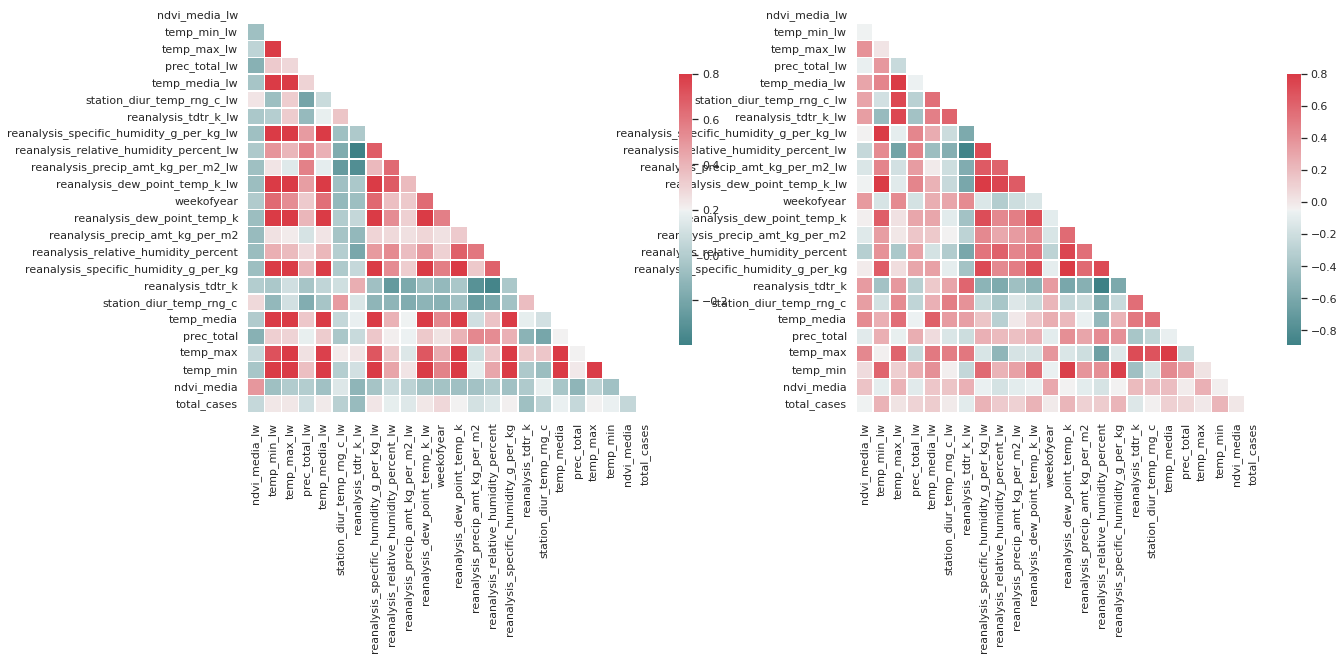

In [21]:
R_sj = train_sj.corr()
R_iq = train_iq.corr()

# Gráfico de la matriz de correlaciones
sns.set(style="whitegrid")
mask = np.zeros_like(R_sj, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, (ax1 , ax2) = plt.subplots(1, 2, figsize=(20, 10))

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(R_sj, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=train_sj.columns, yticklabels=train_sj.columns,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)

sns.heatmap(R_iq, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=train_iq.columns, yticklabels=train_iq.columns,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)

Lo primero que observamos es que las matrices para las dos ciudades son bastante diferentes entre sí, por lo que parece que fue buena idea dividir el problema en dos.

También se observa que existen variables bastante correladas entre sí, como era de esperar: precipitación con la humedad, temperatura mínima con la media, ndvi con temperatura máxima y mínima. De momento no se elimina ninguna más hasta avanzar más con la exploración. 

También se ve que los valores de correlación con total_cases no son muy elevados. Para poder seleccionar mejor las variables, vamos a ordenarlas en función de su correlación co 'total_cases'

(-0.15, 0.3)

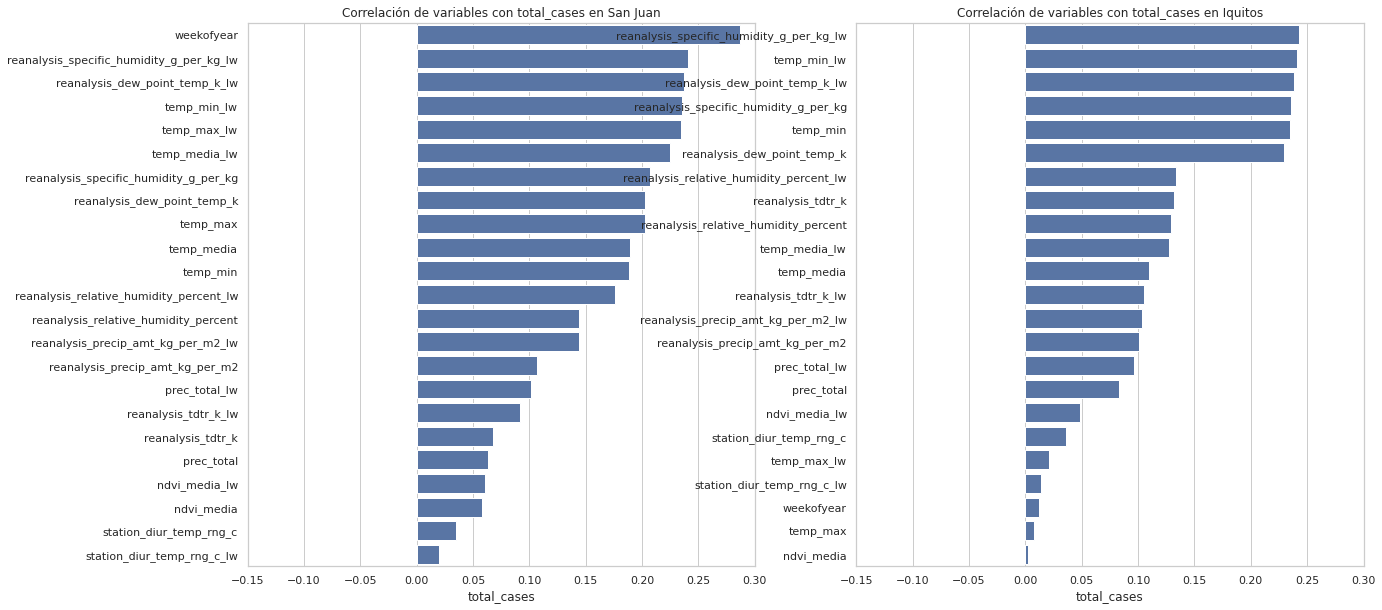

In [22]:
R_sj_ord = abs(R_sj).sort_values(by='total_cases', axis=0, ascending=False).drop('total_cases')
R_iq_ord = abs(R_iq).sort_values(by='total_cases', axis=0, ascending=False).drop('total_cases')

f, (ax1 , ax2) = plt.subplots(1, 2, figsize=(20, 10))
sns.barplot(x=R_sj_ord.total_cases, y=R_sj_ord.index, color="b", ax=ax1)
sns.barplot(x=R_iq_ord.total_cases, y=R_iq_ord.index, color="b", ax=ax2)
ax1.set_title('Correlación de variables con total_cases en San Juan')
ax2.set_title('Correlación de variables con total_cases en Iquitos')
ax1.set_xlim(-0.15,0.30)
ax2.set_xlim(-0.15,0.30)

Otra vez vemos las diferencias entre ambas ciudades. Para San Juan, la variable más correlacionada es la semana del año, lo que nos indica que en esta ciudad la componente estacional es muy importante, pero sin embargo es de las menos correlacionadas para Iquitos.

Otro punto interesante es que muchas de las nuevas variables, con información de las semanas previas, se encuentran en la parte alta, indicando que esta información puede ser más importante que las variables de la propia semana.

Decidimos escoger las 6 variables más correlacionadas de cada ciudad para entrenar a los modelos.

In [23]:
var_sj_elim = R_sj_ord.tail(len(R_sj_ord)-6).index
var_iq_elim = R_iq_ord.tail(len(R_sj_ord)-6).index
train_sj.drop(var_sj_elim, axis=1, inplace=True)
train_iq.drop(var_iq_elim, axis=1, inplace=True)
test_sj.drop(var_sj_elim, axis=1, inplace=True)
test_iq.drop(var_iq_elim, axis=1, inplace=True)
print('Dataframe San Juan: ', train_sj.shape)
print('Dataframe Iquitos: ', train_sj.shape)

Dataframe San Juan:  (936, 7)
Dataframe Iquitos:  (936, 7)


In [24]:
train_sj.head()

,temp_min_lw,temp_max_lw,temp_media_lw,reanalysis_specific_humidity_g_per_kg_lw,reanalysis_dew_point_temp_k_lw,weekofyear,total_cases
0,21.450,28.100,24.919524,14.012857,292.414286,18,4
1,22.800,29.800,25.789524,15.372857,293.951429,19,5
2,22.395,29.290,25.528524,14.964857,293.490286,20,4
3,23.325,29.835,26.024190,16.405857,294.989429,21,3
4,23.620,30.550,26.431095,16.725571,295.347286,22,6


In [25]:
train_iq.head()

,temp_min_lw,reanalysis_specific_humidity_g_per_kg_lw,reanalysis_dew_point_temp_k_lw,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,temp_min,total_cases
0,21.450,14.012857,292.414286,295.184286,16.651429,20.40,0
1,22.800,15.372857,293.951429,295.358571,16.862857,19.45,0
2,19.735,16.799429,295.306286,295.622857,17.120000,20.15,0
3,19.940,17.042857,295.543571,292.797143,14.431429,15.15,0
4,16.650,15.238000,293.644857,293.957143,15.444286,18.80,0


### Eliminación de outliers
Para ver si hay outliers presentes en el dataset, se dibujan los boxplots de cada columna.

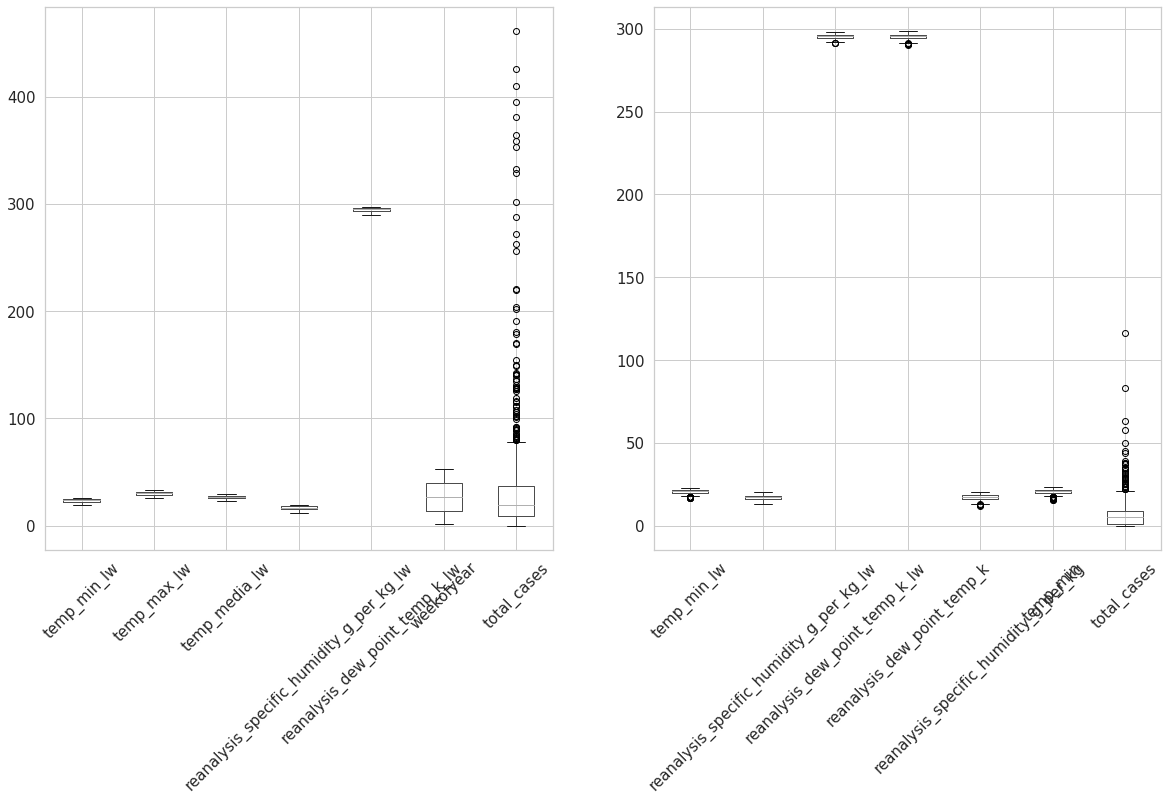

In [26]:
f, (ax1 , ax2) = plt.subplots(1, 2, figsize=(20, 10))
train_sj.boxplot(fontsize=15, rot=45, ax=ax1)
train_iq.boxplot(fontsize=15, rot=45, ax=ax2)

En general, los valores están bastantes agrupados, excepto para el caso de total_cases, por lo que solo se borran los outliers observados en esta variable. Solo se eliminarán los outliers más alejados, ya que al ser la variable objetivo, no queremos que nuestro modelo no tenga valores altos ya que predecira mal estos eventos en ese caso

In [27]:
print('Outliers eliminados para San Juan: ', len(train_sj[train_sj.total_cases > 300]),
    ' (', round((len(train_sj[train_sj.total_cases > 300]))/len(train_sj)*100,2), '%)')
print('Outliers eliminados para Iquitos: ', len(train_iq[train_iq.total_cases > 50]),
    ' (', round((len(train_iq[train_iq.total_cases > 50]))/len(train_iq)*100,2), '%)')


Outliers eliminados para San Juan:  11  ( 1.18 %)
Outliers eliminados para Iquitos:  4  ( 0.77 %)


In [28]:
train_sj.drop(train_sj[train_sj.total_cases > 300].index, inplace=True)
train_iq.drop(train_iq[train_iq.total_cases > 50].index, inplace=True)

Ya que hemos borrado filas, vamos a resetear el índice para volver a ordenar los valores

In [29]:
train_sj.reset_index(inplace=True, drop=True)
train_iq.reset_index(inplace=True, drop=True)

### Normalización
Por último, se normalizan todas las variables para que las técnicas de aprendizaje automático funcionen mejor.

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_sj_norm = scaler.fit_transform(train_sj.drop('total_cases', axis=1))
X_test_sj_norm = scaler.transform(test_sj)
X_train_iq_norm = scaler.fit_transform(train_iq.drop('total_cases', axis=1))
X_test_iq_norm = scaler.transform(test_iq)
print('Máximos train: ', X_train_sj_norm.max(axis=0))
print('Mínimos train: ', X_train_sj_norm.min(axis=0))
print('Máximos test: ', X_test_sj_norm.max(axis=0))
print('Mínimos test: ', X_test_sj_norm.min(axis=0))

Máximos train:  [1. 1. 1. 1. 1. 1.]
Mínimos train:  [0. 0. 0. 0. 0. 0.]
Máximos test:  [1.04351032 0.98868778 0.96129245 1.01584507 1.02007602 1.        ]
Mínimos test:  [0.27654867 0.07616893 0.1689895  0.11215824 0.15236332 0.        ]


# Construcción y evaluación preliminar del modelo

Tras realizar varias pruebas con distintos modelos, el que mejor resultado dió fue el RandomForest por lo que es el que emplearemos.

Para obtener un buen modelo para cada ciudad, hay que optimizar los hiperparámetros del Random Forest. Por lo que se utiliza una búsqueda aleatoria a partir de varios parámetros para encontrar los mejores hiperparámetros en cada caso.

In [31]:
# ATENCIÓN: Tarda 11 minutos en ejecutarse esta celda
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
    
regressor_sj = RandomForestRegressor()
regressor_iq = RandomForestRegressor()

param = {'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

grid_sj = RandomizedSearchCV(estimator= regressor_sj, param_distributions= param, n_iter= 100, cv= 5, random_state= 1, n_jobs= -1)
grid_iq = RandomizedSearchCV(estimator= regressor_iq, param_distributions= param, n_iter= 100, cv= 5, random_state= 1, n_jobs= -1)

grid_sj_fit = grid_sj.fit(X = X_train_sj_norm, y = train_sj.total_cases)
grid_iq_fit = grid_iq.fit(X = X_train_iq_norm, y = train_iq.total_cases)

Los mejores modelos encontrados se muestran a continuación

In [32]:
best_sj = grid_sj_fit.best_estimator_
best_iq = grid_iq_fit.best_estimator_
print("Modelo San Juan: ", best_sj)
print("Modelo Iquitos: ", best_iq)

Modelo San Juan:  RandomForestRegressor(max_depth=70, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=1200)
Modelo Iquitos:  RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=600)


Una vez entrenados nuestros modelos, representamos las predicciones y los casos reales para ver cómo se ajustan

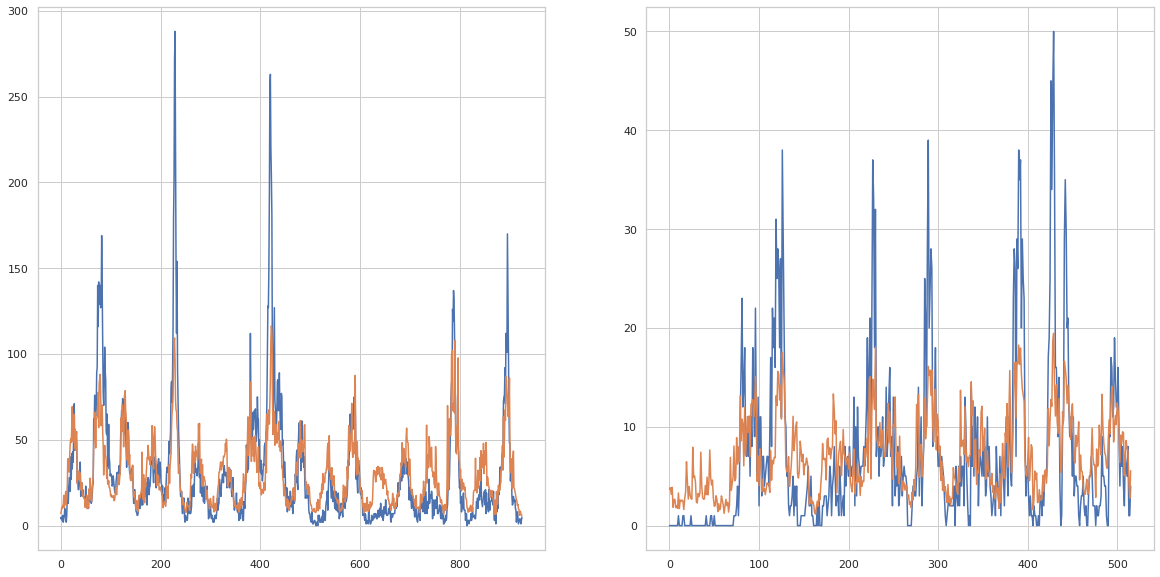

In [33]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

train_sj['predicciones'] = best_sj.predict(X_train_sj_norm)
train_iq['predicciones'] = best_iq.predict(X_train_iq_norm)

train_sj.total_cases.plot(ax=axes[0], label="Real")
train_sj.predicciones.plot(ax=axes[0], label='Predicción')

train_iq.total_cases.plot(ax=axes[1], label="Real")
train_iq.predicciones.plot(ax=axes[1], label='Predicción')

Vemos que los modelos se ajustan bastante bien a los datos excepto en los grandes picos, que el modelo no es capaz de alcanzarlos. También se aleja bastante en los primeros datos de Iquitos, cuando no hubo practicamente casos.

In [34]:
from sklearn.metrics import mean_absolute_error

mae_sj = mean_absolute_error(train_sj.total_cases, train_sj.predicciones)
mae_iq = mean_absolute_error(train_iq.total_cases, train_iq.predicciones)
print("Mean Absolute Error (MAE) San Juan: %.3f" % mae_sj)
print("Mean Absolute Error (MAE) Iquitos: %.3f" % mae_iq)

Mean Absolute Error (MAE) San Juan: 13.466
Mean Absolute Error (MAE) Iquitos: 4.026


Los resultados obtenidos con los datos de entrenamiento son los anteriores, que por ser los datos usados en el entrenamiento, serán mejores que los resultados usando nuevos datos. Pero observamos que el modelo de Iquitos consigue mejores resultados.

# Generación del Resultado Final

Generamos el fichero de salida segun el Submission format

* Realizamos la predicción sobre el test con los dos modelos por separado y luego unimos los resultados




In [35]:
y_pred_sj = best_sj.predict(X_test_sj_norm)
y_pred_iq = best_iq.predict(X_test_iq_norm)

In [36]:
y_pred = np.concatenate((y_pred_sj, y_pred_iq), axis=None)
len(y_pred)

416

* Redondeamos el resultado a un número entero ya que el número de casos solo puede ser entero

In [37]:
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
res

array([  7,   8,  14,  16,  13,  14,  33,  13,  16,  22,  21,  17,  31,
        45,  52,  35,  40,  31,  53, 101,  90,  52,  42,  54,  51,  52,
        67,  35,  37,  37,  37,  25,  32,  26,  31,  25,  33,  33,  22,
        24,  29,  18,  20,  16,  11,   9,  11,  10,   9,  11,   8,  11,
        11,  10,  15,  13,  14,  13,   9,  12,  18,  20,  34,  26,  38,
        44,  38,  38,  37,  37,  42,  44,  40,  39,  73,  38,  40,  47,
        37,  81,  84,  33,  48,  68,  33,  31,  31,  31,  28,  31,  29,
        36,  37,  19,  19,  26,  23,  22,  23,  21,  23,  20,  10,  12,
        13,  12,  21,   9,  21,  21,  58,  73,  54,  49,  52,  84,  79,
        87,  43,  48, 103, 109, 113, 112, 111, 104,  48,  35,  49,  85,
        48,  79,  54,  40,  38,  24,  27,  22,  28,  33,  22,  27,  30,
        29,  25,  17,  16,  19,  17,  11,  10,   9,   9,  13,  16,  10,
        13,  13,  12,  10,  16,  21,  22,  29,  66,  70,  62,  50,  47,
        40,  62,  41,  83,  61, 112,  78,  38,  44,  38,  39,  5

Como los casos no pueden ser negativos, los eliminamos de nuestro resultado en caso de que se hubieran predicho y se sustituyen por 0

In [38]:
y_pred_no_neg = res.copy()
y_pred_no_neg[y_pred < 0] = 0
y_pred_no_neg

array([  7,   8,  14,  16,  13,  14,  33,  13,  16,  22,  21,  17,  31,
        45,  52,  35,  40,  31,  53, 101,  90,  52,  42,  54,  51,  52,
        67,  35,  37,  37,  37,  25,  32,  26,  31,  25,  33,  33,  22,
        24,  29,  18,  20,  16,  11,   9,  11,  10,   9,  11,   8,  11,
        11,  10,  15,  13,  14,  13,   9,  12,  18,  20,  34,  26,  38,
        44,  38,  38,  37,  37,  42,  44,  40,  39,  73,  38,  40,  47,
        37,  81,  84,  33,  48,  68,  33,  31,  31,  31,  28,  31,  29,
        36,  37,  19,  19,  26,  23,  22,  23,  21,  23,  20,  10,  12,
        13,  12,  21,   9,  21,  21,  58,  73,  54,  49,  52,  84,  79,
        87,  43,  48, 103, 109, 113, 112, 111, 104,  48,  35,  49,  85,
        48,  79,  54,  40,  38,  24,  27,  22,  28,  33,  22,  27,  30,
        29,  25,  17,  16,  19,  17,  11,  10,   9,   9,  13,  16,  10,
        13,  13,  12,  10,  16,  21,  22,  29,  66,  70,  62,  50,  47,
        40,  62,  41,  83,  61, 112,  78,  38,  44,  38,  39,  5

In [39]:
len(y_pred)

416

* Generamos el fichero de salida y lo descargamos

In [40]:
# generate output
test_original = pd.read_csv('dengue_features_test.csv')
output = pd.DataFrame({ 'city': test_original['city'], 'year': test_original['year'], 'weekofyear': test_original['weekofyear'], 
                       'total_cases': y_pred_no_neg})

name = 'RandomForest_results.csv'
output.to_csv(name, index= False)
from google.colab import files

files.download(name)

output.head()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,7
1,sj,2008,19,8
2,sj,2008,20,14
3,sj,2008,21,16
4,sj,2008,22,13


Por último representamos los resultados para ver qué forma tienen

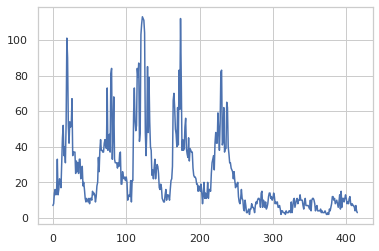

In [41]:
output.total_cases.plot()

Tras subir los resultados a DrivenData, se obtuvo la siguiente puntuación:

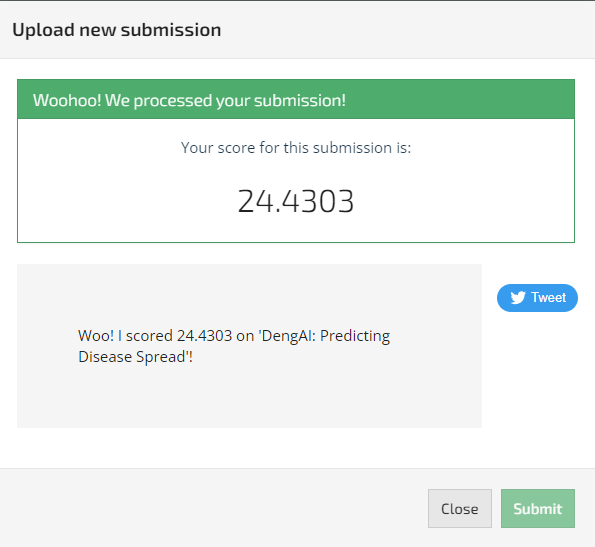